In [49]:
import pandas as pd
import numpy as np
import itertools
from math import pi
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data

In [69]:
df_customers = pd.read_pickle('../../data/customers.pkl')
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93406 entries, 0 to 93810
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   customer_unique_id              93406 non-null  object        
 1   first_order_date                93406 non-null  datetime64[ns]
 2   last_order_date                 93406 non-null  datetime64[ns]
 3   total_orders                    93406 non-null  int64         
 4   average_processing_time         93406 non-null  float64       
 5   cancelled_orders                93406 non-null  int64         
 6   total_expenses                  93406 non-null  float64       
 7   total_items_values              93406 non-null  float64       
 8   total_freight_value             93406 non-null  float64       
 9   average_order_value             93406 non-null  float64       
 10  average_freight_value           93406 non-null  float64       
 11  average

In [70]:
# Convert category col to int
df_customers["usual_moment_of_order_int"] = df_customers[
    "usual_moment_of_order_int"
].astype(int)

In [71]:
current_date = df_customers["last_order_date"].max()
# replace 0 days by 1 day to avoid having 0
df_customers["days_since_last_order"] = df_customers["days_since_last_order"].apply(
    lambda x: 1 if x == 0 else x
)
scaler = StandardScaler()

In [73]:
cols = [
    "days_since_last_order",
    "total_orders",
    "total_expenses",
    "average_review_score",
    "average_delivery_delays",
    "average_days_late",
    "usual_moment_of_order_int",
    "usual_moment_of_order_str",
]

df_customers = df_customers[cols]

In [5]:
# RFM features : Recency, Frequency, Monetary
base_features = ["days_since_last_order", "total_orders", "total_expenses"]
base_features_no_recency = ["total_orders", "total_expenses"]
base_features_no_freq = ["days_since_last_order", "total_expenses"]

# Functions

## Distribution

In [6]:
# Plot distribution
def scale_data_and_plot_distributions(original_df: pd.DataFrame, features: list[str], exclude : list[str] = None,  plot: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Apply logarithm transformation
    df = original_df[features].copy()

    log_df = df.copy()
    to_scale = [col for col in df.columns if col not in exclude] if exclude else df.columns.tolist()
    log_df[to_scale] = np.log1p(log_df[to_scale])


    if plot:
        fig, axes = plt.subplots(len(features), 2, figsize=(20, 12))

        for i, feature in enumerate(df.columns):
            sns.histplot(df[feature], kde=True, ax=axes[i, 0], legend=False)
            axes[i, 0].set_title(f"{feature} original distribution")
            axes[i, 0].set_xlabel("Value")
            axes[i, 0].set_ylabel("Count")

            sns.histplot(log_df[feature], kde=True, ax=axes[i, 1], legend=False)
            axes[i, 1].set_title(f"{feature} log distribution")
            axes[i, 1].set_xlabel("Value")
            axes[i, 1].set_ylabel("Count")


        plt.tight_layout()
        plt.show()

    return df, log_df

## Plot

In [7]:
def plot_3d_clusters(df):
    fig = go.Figure()

    # Add traces for each cluster
    for cluster in sorted(df["cluster"].unique()):
        cluster_data = df[df["cluster"] == cluster]
        fig.add_trace(
            go.Scatter3d(
                x=cluster_data[cluster_data.columns[0]],
                y=cluster_data[cluster_data.columns[1]],
                z=cluster_data[cluster_data.columns[2]],
                mode="markers",
                marker=dict(size=4),
                name=f"Cluster {cluster}",
                text=cluster_data.index,  # Add index as text for annotation
                hoverinfo="text+x+y+z",
            )
        )

    fig.update_layout(
        title=f"Clusters 3D representation with {len(df["cluster"].unique())} clusters and {len(df.columns.to_list())-1} features",
        scene=dict(
            xaxis_title=df.columns[0],
            yaxis_title=df.columns[1],
            zaxis_title=df.columns[2],
        ),
        legend=dict(title="Clusters"),
    )

    fig.show()


In [8]:
# Plot a radar chart of the clusters
def plot_radar_chart(df):
    # Calculate the mean of each feature for each cluster
    cluster_means = df.groupby('cluster').mean()

    # Number of variables we're plotting
    categories = list(cluster_means.columns)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variables)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Loop through each cluster and plot
    for i, row in cluster_means.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)

    # Add labels
    plt.xticks(angles[:-1], categories)

    # Add a title and legend
    plt.title('Radar Chart for Clusters')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()

    fig.show()

In [9]:
def plot_two_dim_clusters(df: pd.DataFrame, scaled_df: pd.DataFrame, k: int):
    """Plots clusters after reducing the data to 2 dimensions using PCA

    Args:
        df (pd.DataFrame): original dataframe
        scaled_df (pd.DataFrame): dataframe with scaled features used for clustering
        k (int): number of clusters to try
    """
    pca = PCA(n_components=2)
    reduced_df = pca.fit_transform(scaled_df)
    features_names = df.columns.tolist()

    model = KMeans(k, random_state=42, max_iter=300)
    labels = model.fit_predict(reduced_df)

    # Add cluster to the original dataframe
    df["cluster"] = labels

    # Plot clusters
    u_labels = np.unique(labels)
    plt.figure(figsize=(10, 10))
    for i in u_labels:
        plt.scatter(
            reduced_df[labels == i, 0],
            reduced_df[labels == i, 1],
            label=f"Cluster {i}",
        )
    # take cluster out of the features list
    features_names.remove("cluster")
    plt.legend()
    plt.title(f"Clusters with k={k} for {features_names}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

## Benchmark

In [75]:
def benchmark_clusters(labelled_df: pd.DataFrame) -> pd.DataFrame:
    """Evaluate the clusters by comparing the mean of the features for each cluster with the original data.

    Args:
        labelled_df (pd.DataFrame): The dataframe with original values and the clusters.
    Returns:
        pd.DataFrame: a dataframe with all data aggregated by cluster
    """
    df_labelled = labelled_df.copy()
    agg_functions = {
        "cluster": [
            "count",
            lambda x: round(x.count() / df_labelled.shape[0] * 100, 2),
        ],
        "days_since_last_order": lambda x: round(x.mean(), 2),
        "total_orders": "mean",
        "total_expenses": [
            lambda x: round(x.mean(), 2),
            "sum",
            lambda x: round((x.sum() / (df_labelled["total_expenses"].sum())) * 100, 2),
        ],
        "average_review_score": lambda x: round(x.mean(), 2),
        "average_delivery_delays": lambda x: round(x.mean(), 2),
        "average_days_late": lambda x: round(x.mean(), 2),
        "usual_moment_of_order_str": lambda x: x.mode(),
    }

    rename_columns = {
        "clusters_": "cluster",
        "cluster_count": "customers",
        "cluster_<lambda_0>": "customers(%)",
        "total_orders_mean": "average_orders",
        "total_expenses_<lambda_0>": "average_basket(real)",
        "total_expenses_sum": "total_revenues(real)",
        "total_expenses_<lambda_1>": "total_revenues(%)",
        "days_since_last_order_<lambda>": "average_recency",
        "average_review_score_<lambda>": "average_review_score",
        "average_delivery_delays_<lambda>": "delivery(days)",
        "average_days_late_<lambda>": "late_deliveries(days)",
        "usual_moment_of_order_str_<lambda>": "usual_moment_of_order"
    }

    # Group by cluster and calculate means and ratios
    clusters_summary = df_labelled.groupby("cluster").agg(agg_functions).reset_index()

    # Flatten the MultiIndex columns
    clusters_summary.columns = [
        "_".join(col).strip() if isinstance(col, tuple) else col
        for col in clusters_summary.columns.values
    ]

    # Rename the columns
    clusters_summary = clusters_summary.rename(columns=rename_columns)

    display(clusters_summary)

    return df_labelled

# Test on additional features

## Reviews

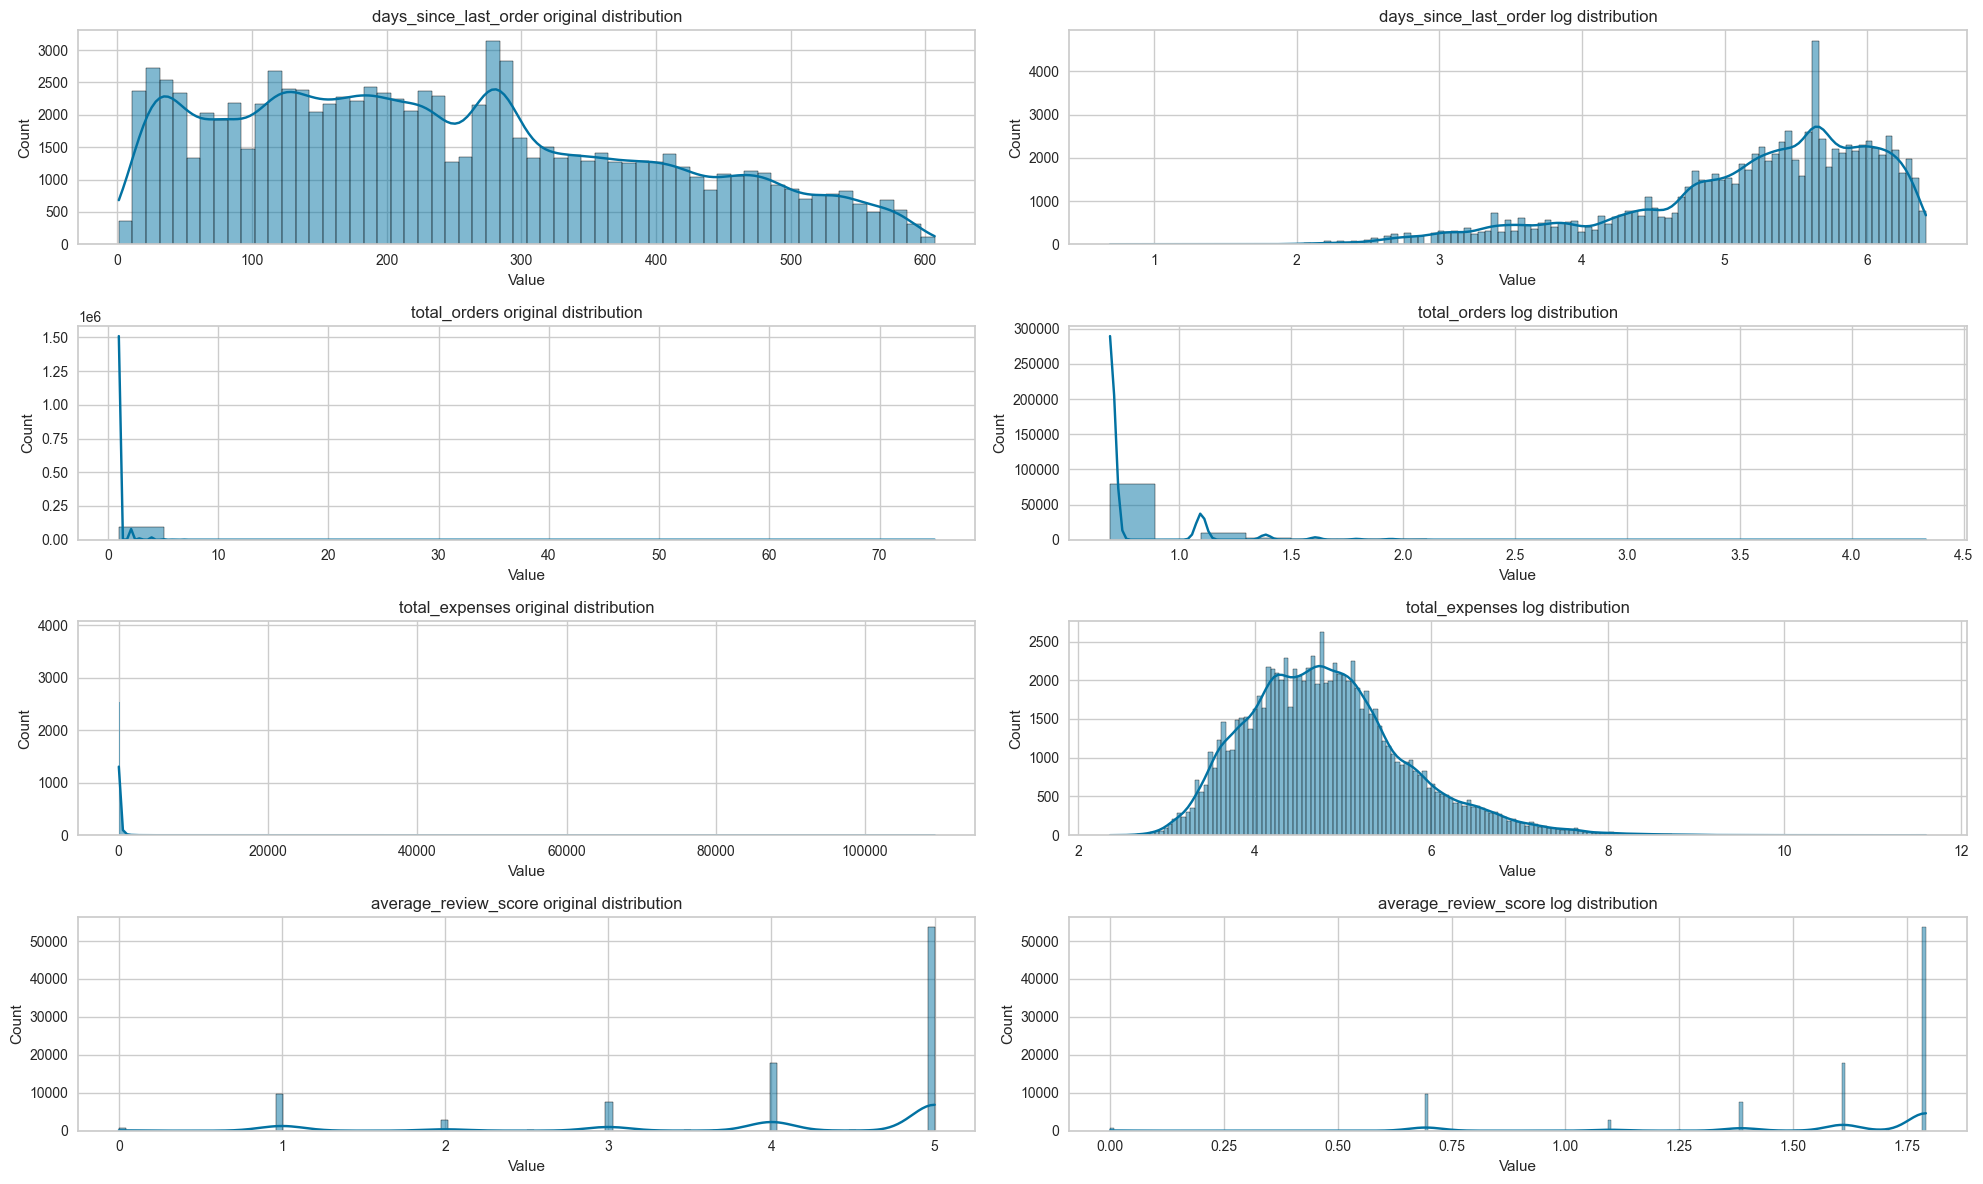

In [109]:
features = base_features + ["average_review_score"]
df_reviews, scaled_df_reviews = scale_data_and_plot_distributions(
    df_customers, features, plot=True
)
# scaler = StandardScaler()
# scaled_df_reviews = scaler.fit_transform(scaled_df_reviews)

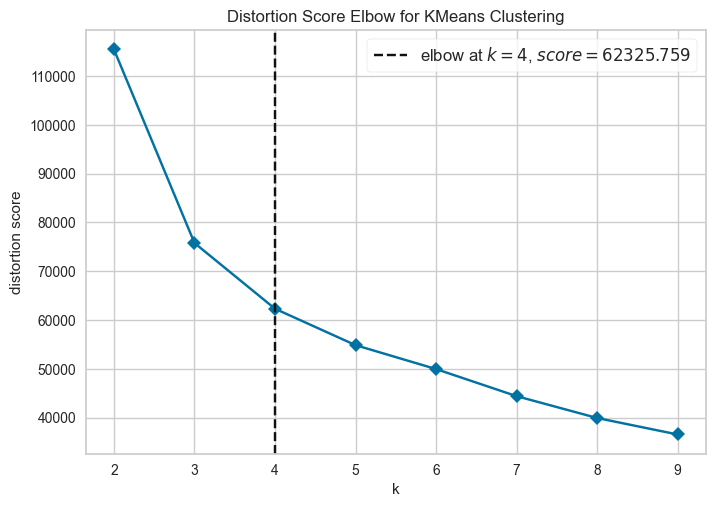

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=False)

visualizer.fit(scaled_df_reviews)
visualizer.poof()

In [111]:
for k in range(3,5):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_reviews)

    silhouette = silhouette_score(scaled_df_reviews, df_labels["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)

Silhouette score for 3 clusters: 0.34646714521038596


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,27460,29.40,270.13,1.594246,494.31,13573679.40,68.03,3.88,14.17,0.94,Evening
1,1,47524,50.88,299.37,1.072027,79.74,3789475.33,18.99,4.12,12.84,0.76,Evening
2,2,18422,19.72,53.37,1.138964,140.53,2588871.97,12.98,4.30,8.82,0.25,Evening


Silhouette score for 4 clusters: 0.2973082674569436


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,11718,12.55,236.41,2.070661,871.81,10215902.24,51.20,3.72,13.74,0.86,Evening
1,1,30818,32.99,289.06,1.053670,56.03,1726672.78,8.65,4.15,12.31,0.69,Evening
2,2,33827,36.22,298.31,1.174535,170.18,5756794.98,28.85,4.04,14.00,0.92,Evening
3,3,17043,18.25,50.40,1.128909,132.17,2252656.70,11.29,4.31,8.68,0.24,Evening


### Without recency

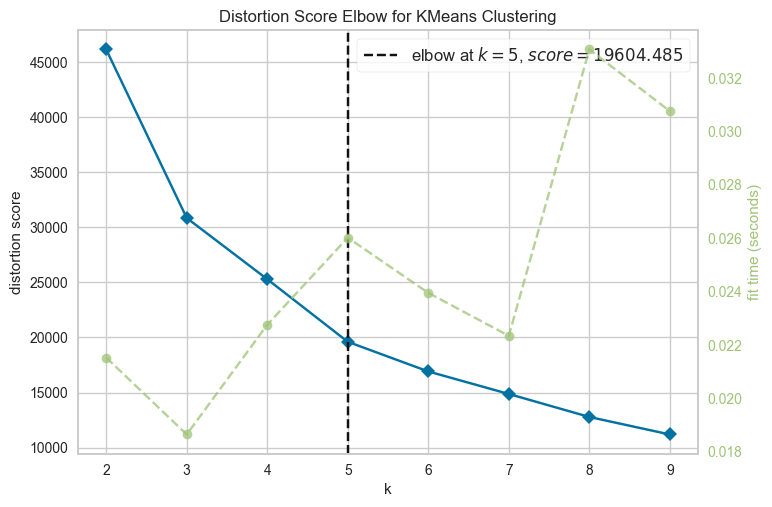

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
features = base_features_no_recency + ["average_review_score"]
df_reviews_no_recency, scaled_df_reviews_no_recency = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
# scaled_df_reviews_no_recency = scaler.fit_transform(scaled_df_reviews_no_recency)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_reviews_no_recency)
visualizer.poof()

In [79]:
for k in range(3, 6):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=0)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_reviews_no_recency)

    silhouette = silhouette_score(scaled_df_reviews_no_recency, df_labels["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)


Silhouette score for 3 clusters: 0.4128570965047183


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,37289,39.92,245.28,1.051651,55.93,2085661.45,10.45,4.18,11.44,0.60,Evening
1,1,13973,14.96,242.06,1.986617,792.34,11071302.50,55.49,3.77,13.46,0.81,Evening
2,2,42144,45.12,239.65,1.156345,161.23,6795062.75,34.06,4.11,12.98,0.78,Evening


Silhouette score for 4 clusters: 0.44754329677622473


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,34237,36.65,245.26,1.050764,54.82,1876905.79,9.41,4.43,10.75,0.31,Evening
1,1,13132,14.06,241.13,2.016905,823.10,10808982.95,54.17,3.83,13.31,0.75,Evening
2,2,37349,39.99,239.12,1.153498,163.06,6090168.82,30.52,4.57,11.85,0.27,Evening
3,3,8688,9.30,245.64,1.169890,135.36,1175969.14,5.89,1.08,20.29,4.16,Evening


Silhouette score for 5 clusters: 0.4005840889959505


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,30769,32.94,242.56,1.077611,98.04,3016634.71,15.12,4.57,11.40,0.24,Evening
1,1,8987,9.62,239.72,2.250918,1035.25,9303780.02,46.63,3.64,13.59,0.84,Evening
2,2,23578,25.24,239.50,1.258673,232.29,5476968.81,27.45,4.53,12.19,0.30,Evening
3,3,8506,9.11,245.75,1.188338,145.11,1234284.41,6.19,1.07,20.33,4.17,Evening
4,4,21566,23.09,244.53,1.044978,42.68,920358.75,4.61,4.28,10.60,0.41,Evening


## Delays

In [80]:
delays_features = ["average_delivery_delays", "average_days_late"]
features = base_features + delays_features

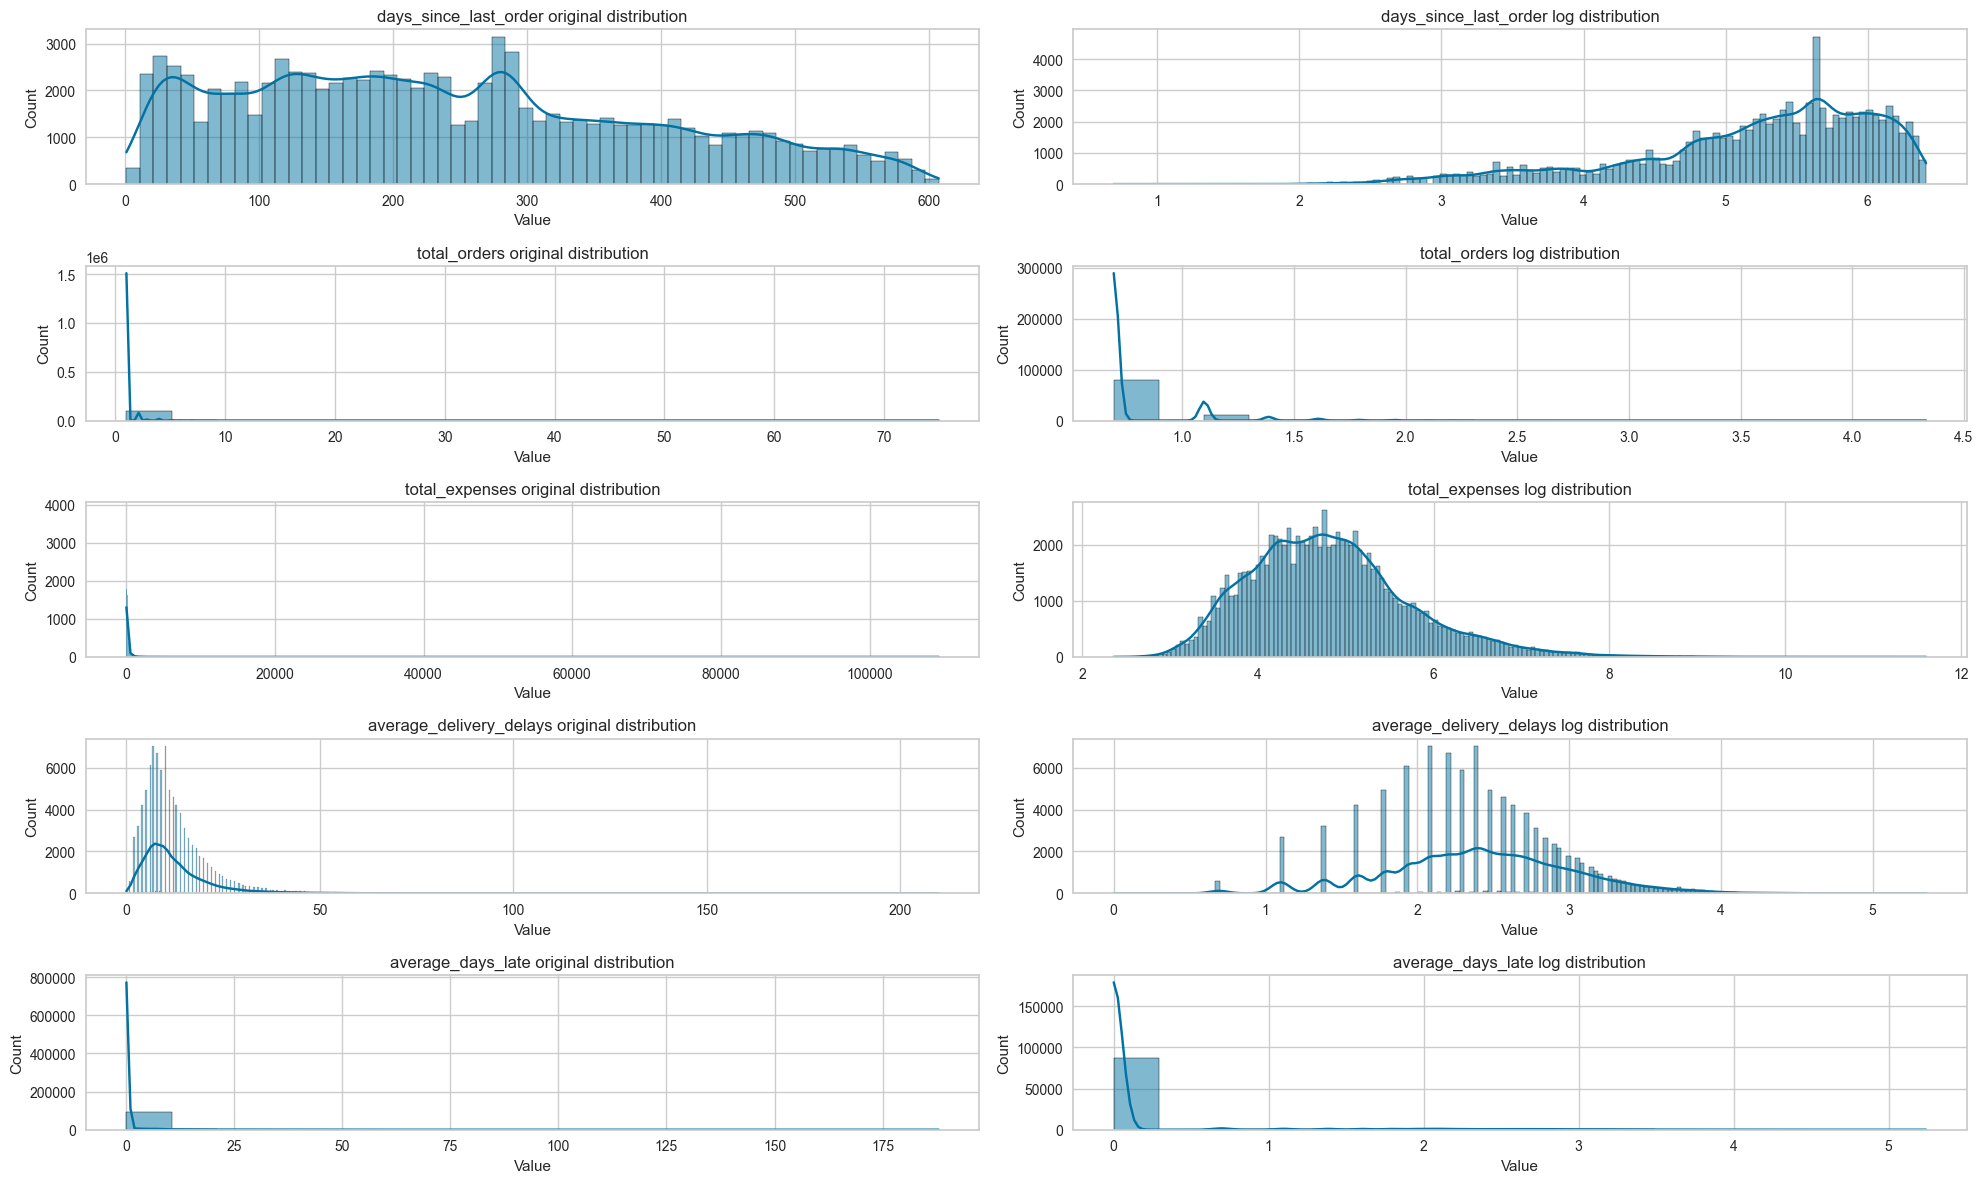

In [81]:
df_deliveries, scaled_df_deliveries = scale_data_and_plot_distributions(
    df_customers, features, plot=True
)
# scaled_df_deliveries = scaler.fit_transform(scaled_df_deliveries)

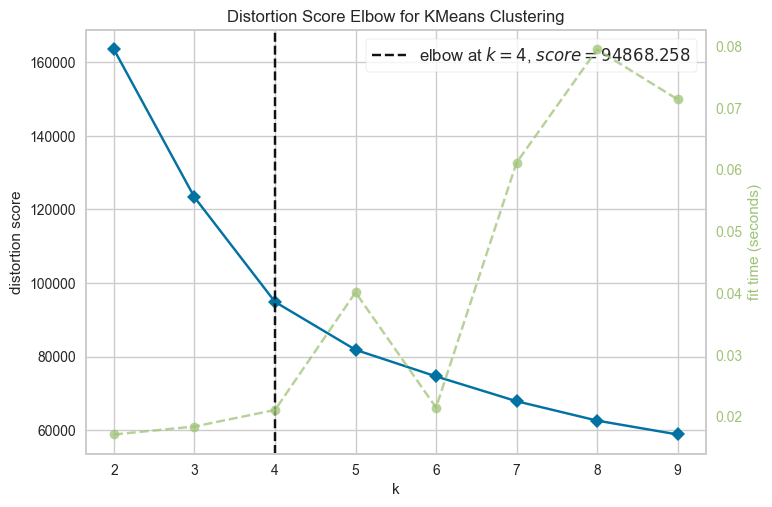

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [82]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_deliveries)
visualizer.poof()

In [83]:
for k in range(3,5):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_deliveries)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_deliveries, kmeans.labels_)
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)

Results for 3 clusters
Silhouette score for 3 clusters: 0.3230168474429548


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,5172,5.54,234.06,1.203596,226.80,1173028.25,5.88,1.96,36.81,12.49,Evening
1,1,24359,26.08,67.94,1.214253,194.38,4734893.17,23.73,4.32,7.86,0.04,Evening
2,2,63875,68.38,309.40,1.250943,219.87,14044105.28,70.39,4.17,12.21,0.01,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.31762712443292984


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4941,5.29,235.04,1.176482,202.16,998894.86,5.01,1.91,37.39,12.94,Evening
1,1,18410,19.71,55.03,1.139652,137.15,2524888.27,12.65,4.34,7.68,0.05,Evening
2,2,44748,47.91,304.42,1.074528,80.42,3598674.14,18.04,4.25,11.46,0.02,Evening
3,3,25307,27.09,269.96,1.613388,506.96,12829569.43,64.30,4.04,12.75,0.03,Evening


### Deliveries

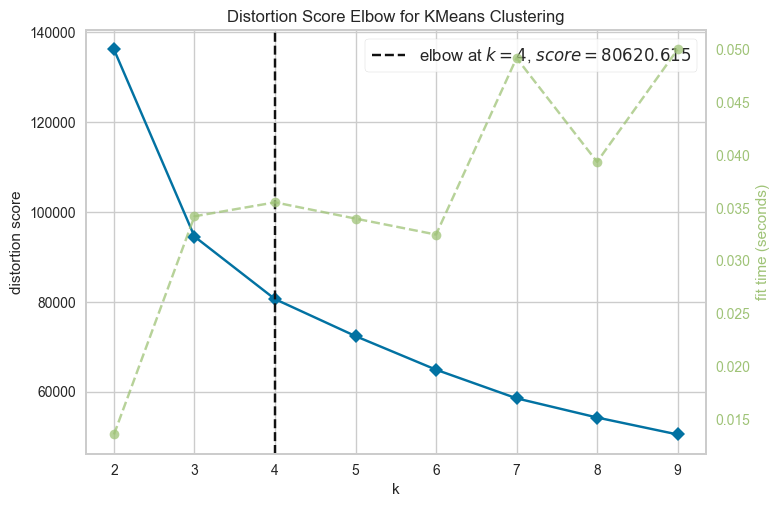

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [84]:
delays_features = ["average_delivery_delays"]
features = base_features + delays_features
df_deliveries, scaled_df_deliveries = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_deliveries)
visualizer.poof()

In [85]:
for k in range(3, 5):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_deliveries)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_deliveries, kmeans.labels_)
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)

Results for 3 clusters
Silhouette score for 3 clusters: 0.3068667426087234


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,27096,29.01,268.15,1.594737,498.90,13518160.79,67.75,3.87,14.79,1.04,Evening
1,1,47336,50.68,302.04,1.073876,80.77,3823503.94,19.16,4.11,12.95,0.74,Evening
2,2,18974,20.31,56.15,1.141720,137.58,2610361.97,13.08,4.32,7.79,0.17,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.25272551865040277


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,12767,13.67,244.69,2.018877,824.04,10520512.83,52.73,3.82,12.81,0.60,Evening
1,1,33627,36.00,295.12,1.154013,160.50,5397300.66,27.05,3.94,16.51,1.43,Evening
2,2,17643,18.89,53.06,1.134954,133.47,2354859.08,11.80,4.32,7.84,0.18,Evening
3,3,29369,31.44,294.34,1.059008,57.18,1679354.13,8.42,4.23,10.37,0.26,Evening


### Late deliveries

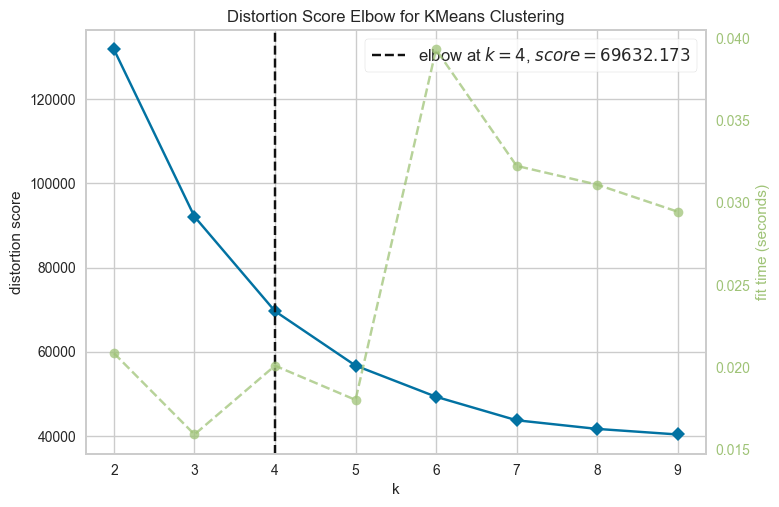

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [112]:
delays_features = ["average_days_late"]
features = base_features + delays_features
df_deliveries, scaled_df_deliveries = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_deliveries)
visualizer.poof()


In [87]:
for k in range(3, 5):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_deliveries)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_deliveries, kmeans.labels_)
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)

Results for 3 clusters
Silhouette score for 3 clusters: 0.3697994215902848


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4876,5.22,234.92,1.214930,231.66,1129586.98,5.66,1.89,37.29,13.12,Evening
1,1,24377,26.10,66.99,1.276244,258.28,6296206.84,31.56,4.27,8.95,0.05,Evening
2,2,64153,68.68,309.42,1.226318,195.26,12526232.88,62.78,4.18,11.87,0.02,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.37983108833114565


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4670,5.00,234.22,1.171520,194.11,906478.82,4.54,1.86,37.80,13.54,Evening
1,1,18234,19.52,53.71,1.137161,138.37,2523034.88,12.65,4.32,8.47,0.06,Evening
2,2,45416,48.62,303.00,1.073961,80.66,3663252.41,18.36,4.25,11.43,0.02,Evening
3,3,25086,26.86,270.83,1.623455,512.61,12859260.59,64.45,4.04,12.43,0.04,Evening


## Reviews and delays

In [88]:
rev_delay_features = ["average_review_score"] + delays_features
features = base_features + rev_delay_features
print(features)

['days_since_last_order', 'total_orders', 'total_expenses', 'average_review_score', 'average_days_late']


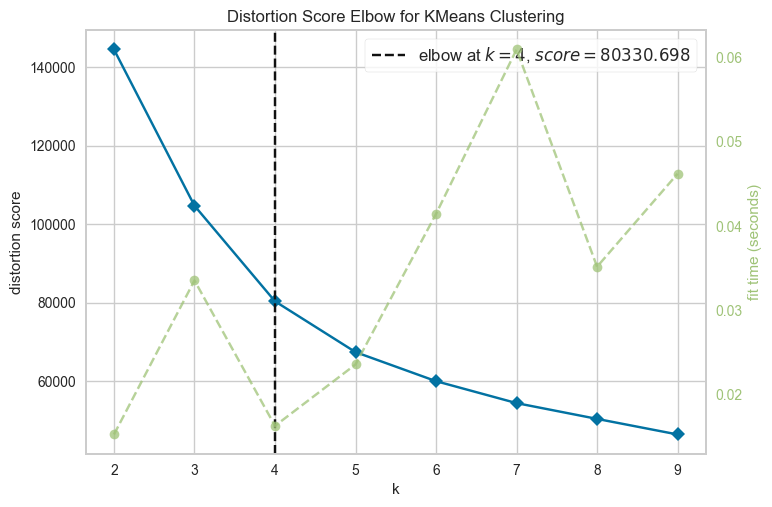

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [89]:
df_rev_del, scaled_df_rev_del = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
# scaler= StandardScaler()
# scaled_df_rev_del = scaler.fit_transform(scaled_df_rev_del)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_rev_del)
visualizer.poof()

In [90]:
for k in range(3,5):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=19, n_init=10, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_rev_del)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_rev_del, df_labels["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)

Results for 3 clusters
Silhouette score for 3 clusters: 0.31897118205924774


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,47669,51.03,300.18,1.072584,80.26,3826126.58,19.18,4.13,12.75,0.70,Evening
1,1,27139,29.05,269.58,1.599396,498.30,13523412.89,67.78,3.85,14.44,1.09,Evening
2,2,18598,19.91,53.94,1.138402,139.93,2602487.23,13.04,4.31,8.73,0.20,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.3506574513004025


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,25249,27.03,271.51,1.619747,509.04,12852810.31,64.42,4.03,12.43,0.04,Evening
1,1,18286,19.58,54.00,1.137537,138.77,2537630.19,12.72,4.34,8.46,0.05,Evening
2,2,45144,48.33,303.07,1.073476,80.25,3622913.68,18.16,4.26,11.41,0.02,Evening
3,3,4727,5.06,233.50,1.173683,198.58,938672.52,4.70,1.79,37.63,13.42,Evening


### Without frequency

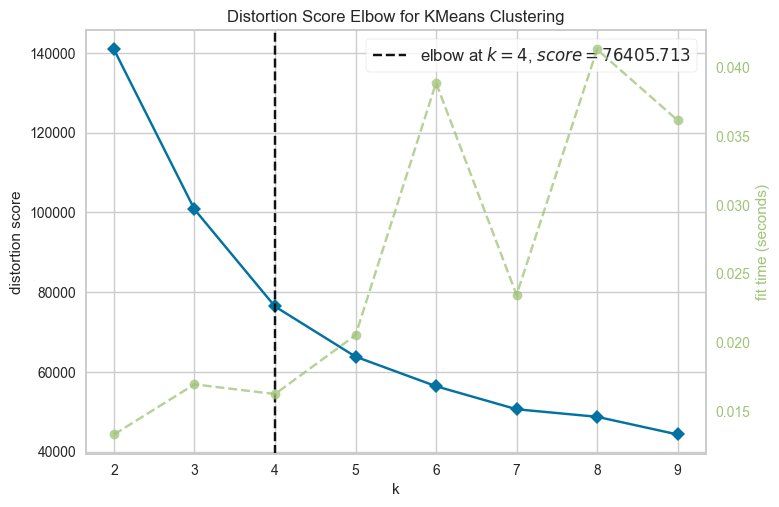

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [91]:
features = base_features_no_freq + rev_delay_features
df_rev_del, log_df_rev_del = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
# scaled_df_rev_del = scaler.fit_transform(scaled_df_rev_del)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(log_df_rev_del)
visualizer.poof()

In [92]:
for k in range(3, 5):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_rev_del)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_rev_del, df_labels["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)

Results for 3 clusters
Silhouette score for 3 clusters: 0.3266326282330189


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4938,5.29,232.02,1.191171,214.77,1060557.59,5.32,1.82,36.96,13.01,Evening
1,1,55330,59.24,307.24,1.103091,101.10,5593906.90,28.04,4.25,11.42,0.02,Evening
2,2,33138,35.48,135.29,1.472358,401.28,13297562.21,66.65,4.15,10.48,0.03,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.3514327498719598


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4724,5.06,233.37,1.172947,196.25,927067.79,4.65,1.79,37.64,13.42,Evening
1,1,45544,48.76,303.02,1.074060,80.94,3686529.28,18.48,4.26,11.42,0.02,Evening
2,2,24913,26.67,270.69,1.627544,514.75,12823896.03,64.27,4.02,12.43,0.04,Evening
3,3,18225,19.51,53.86,1.135912,137.97,2514533.60,12.60,4.34,8.46,0.05,Evening


### Without recency

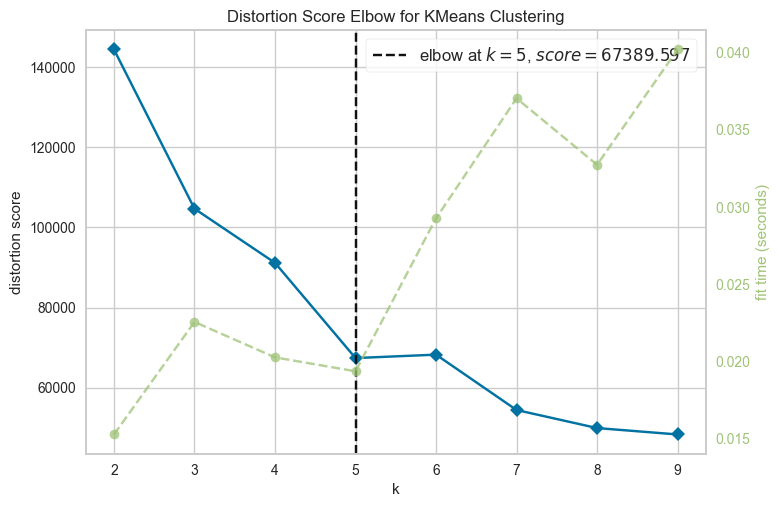

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
features = base_features_no_recency + rev_delay_features
df_rev_del, log_df_rev_del = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
# scaled_df_rev_del = scaler.fit_transform(log_df_rev_del)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_rev_del)
visualizer.poof()


In [94]:
for k in range(4, 6):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_rev_del)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_rev_del, df_labels["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)

Results for 4 clusters
Silhouette score for 4 clusters: 0.3514327498719598


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4724,5.06,233.37,1.172947,196.25,927067.79,4.65,1.79,37.64,13.42,Evening
1,1,45544,48.76,303.02,1.074060,80.94,3686529.28,18.48,4.26,11.42,0.02,Evening
2,2,24913,26.67,270.69,1.627544,514.75,12823896.03,64.27,4.02,12.43,0.04,Evening
3,3,18225,19.51,53.86,1.135912,137.97,2514533.60,12.60,4.34,8.46,0.05,Evening


Results for 5 clusters
Silhouette score for 5 clusters: 0.3038169149136163


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4672,5.00,232.89,1.166310,187.10,874130.26,4.38,1.78,37.70,13.51,Evening
1,1,31636,33.87,303.30,1.178183,171.10,5412920.26,27.13,4.20,12.26,0.02,Evening
2,2,10993,11.77,235.08,2.106067,892.34,9809460.53,49.17,3.84,12.27,0.09,Evening
3,3,29179,31.24,291.24,1.053737,55.77,1627299.33,8.16,4.27,11.00,0.03,Evening
4,4,16926,18.12,50.98,1.127614,131.64,2228216.32,11.17,4.34,8.38,0.05,Evening


## Time fo the day a customer usually order

In [95]:
time_of_the_day_feature = ["usual_moment_of_order_int"]
features = base_features + time_of_the_day_feature

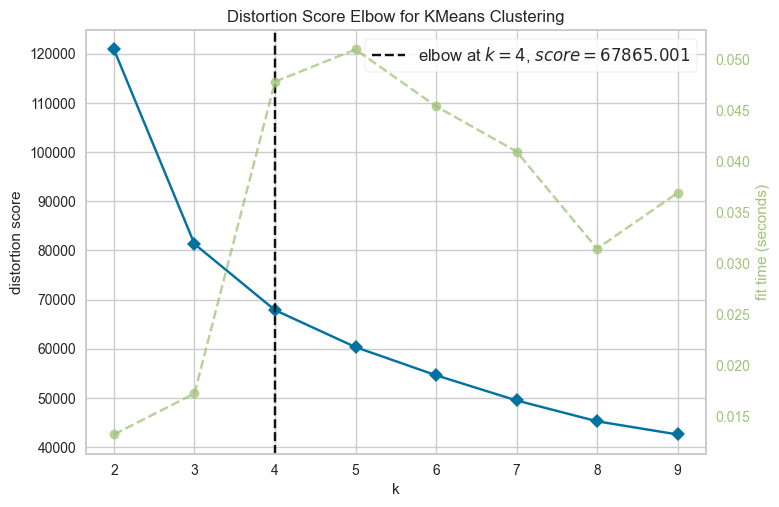

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
df_ordering_time, scaled_df_ordering_time = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
# scaled_df_ordering_time = scaler.fit_transform(scaled_df_ordering_time)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_ordering_time)
visualizer.poof()

In [97]:
for k in range(3,7):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_ordering_time)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_ordering_time, df_labels["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)

Results for 3 clusters
Silhouette score for 3 clusters: 0.3293933943465266


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,27079,28.99,269.35,1.600244,499.56,13527670.21,67.80,3.90,14.13,0.93,Evening
1,1,18459,19.76,53.56,1.138902,139.49,2574880.44,12.91,4.28,8.85,0.26,Evening
2,2,47868,51.25,299.70,1.072763,80.42,3849476.05,19.29,4.11,12.87,0.76,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.27637980092615155


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,11731,12.56,236.55,2.065723,871.57,10224411.49,51.24,3.78,13.65,0.82,Evening
1,1,17056,18.26,50.46,1.129163,132.02,2251802.38,11.29,4.29,8.70,0.24,Evening
2,2,30833,33.01,289.16,1.053482,56.04,1727838.25,8.66,4.14,12.35,0.71,Evening
3,3,33786,36.17,298.26,1.176020,170.13,5747974.58,28.81,4.04,13.99,0.92,Evening


Results for 5 clusters
Silhouette score for 5 clusters: 0.2565309205749799


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,25065,26.83,365.01,1.188550,173.36,4345286.68,21.78,4.08,13.66,0.75,Evening
1,1,11452,12.26,35.00,1.131767,130.51,1494606.93,7.49,4.29,8.13,0.28,Evening
2,2,27101,29.01,296.27,1.051585,52.68,1427692.51,7.16,4.14,12.30,0.69,Evening
3,3,18750,20.07,129.95,1.134080,143.94,2698819.84,13.53,4.09,12.81,0.88,Evening
4,4,11038,11.82,236.72,2.101105,904.66,9985620.74,50.05,3.75,13.82,0.85,Evening


Results for 6 clusters
Silhouette score for 6 clusters: 0.2582035245273545


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,12359,13.23,297.16,1.100089,100.59,1243224.99,6.23,4.09,13.19,0.82,Morning
1,1,10899,11.67,36.15,1.106799,110.36,1202833.58,6.03,4.30,7.92,0.27,Evening
2,2,21672,23.20,357.31,1.196106,181.21,3927235.82,19.68,4.05,14.08,0.88,Evening
3,3,14970,16.03,111.95,1.199399,193.70,2899623.60,14.53,4.13,12.02,0.61,Evening
4,4,9615,10.29,253.33,2.187728,980.70,9429386.82,47.26,3.73,13.93,0.85,Evening
5,5,23891,25.58,280.72,1.052112,52.31,1249721.89,6.26,4.14,12.28,0.71,Evening


## Reviews + delays + moment of order

Number of features:  6


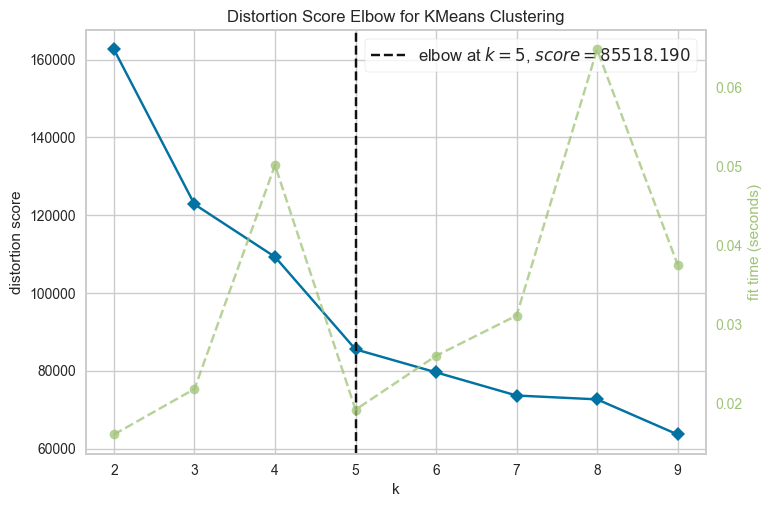

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [98]:
## Clustering with all features
features = base_features + rev_delay_features + time_of_the_day_feature
print("Number of features: ", len(features))

df_all, scaled_df_all = scale_data_and_plot_distributions(
    df_customers,
    features,
    # exclude=["average_review_score"],
    plot=False,
)
# scaled_df_all = scaler.fit_transform(scaled_df_all)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_all)
visualizer.poof()

In [99]:
for k in range(3,5):
    kmean_log = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=0, max_iter=300)

    kmean_log["cluster"] = kmeans.fit_predict(scaled_df_all)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_all, kmean_log["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(kmean_log)

Results for 3 clusters
Silhouette score for 3 clusters: 0.28036689185825125


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,48033,51.42,299.83,1.073075,80.78,3880257.83,19.45,4.13,12.76,0.71,Evening
1,1,18508,19.81,53.67,1.138265,139.78,2587094.17,12.97,4.31,8.72,0.20,Evening
2,2,26865,28.76,269.25,1.604206,501.94,13484674.70,67.59,3.85,14.42,1.08,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.22763326148050875


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,30638,32.80,290.54,1.055356,56.22,1722552.71,8.63,4.22,11.65,0.33,Evening
1,1,17187,18.40,50.88,1.128527,132.17,2271523.89,11.38,4.31,8.64,0.21,Evening
2,2,11752,12.58,237.37,2.069860,870.36,10228444.89,51.27,3.77,13.39,0.67,Evening
3,3,33829,36.22,297.47,1.172130,169.37,5729505.21,28.72,3.97,14.75,1.32,Evening


### Without the frequency

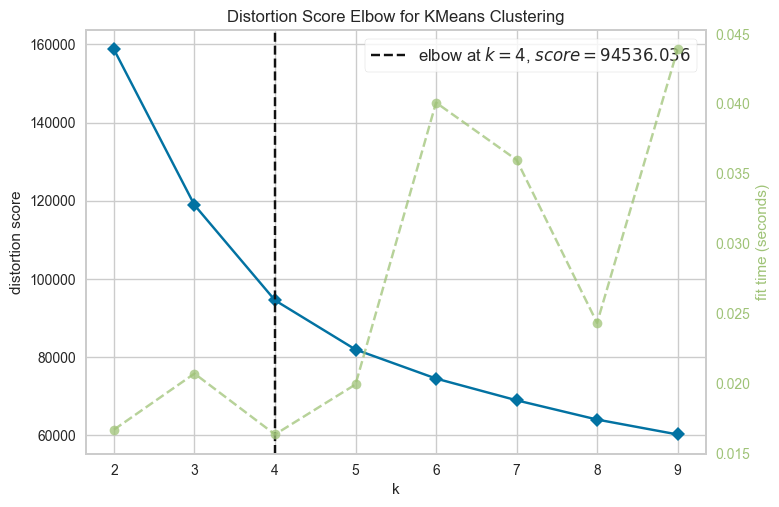

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [100]:
features = base_features_no_freq + rev_delay_features + time_of_the_day_feature
df_all_no_fqcy, scaled_df_all_no_fqcy = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
# scaled_df_all_no_fqcy = scaler.fit_transform(scaled_df_all_no_fqcy)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_all_no_fqcy)
visualizer.poof()

In [101]:
for k in range(3, 5):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_all_no_fqcy)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_all_no_fqcy, df_labels["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)


Results for 3 clusters
Silhouette score for 3 clusters: 0.2901150172010869


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4926,5.27,231.74,1.191839,213.94,1053859.34,5.28,1.82,36.96,13.04,Evening
1,1,54246,58.08,304.38,1.099639,95.48,5179511.83,25.96,4.25,11.33,0.02,Evening
2,2,34234,36.65,145.34,1.465940,400.73,13718655.53,68.76,4.15,10.66,0.03,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.3109325859428228


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4726,5.06,233.43,1.176894,199.57,943182.41,4.73,1.79,37.64,13.43,Evening
1,1,44742,47.90,302.98,1.077712,79.44,3554436.29,17.81,4.26,11.40,0.02,Evening
2,2,18209,19.49,53.66,1.142951,139.59,2541799.61,12.74,4.34,8.45,0.05,Evening
3,3,25729,27.55,271.76,1.597963,501.87,12912608.39,64.72,4.03,12.43,0.04,Evening


### Without the recency

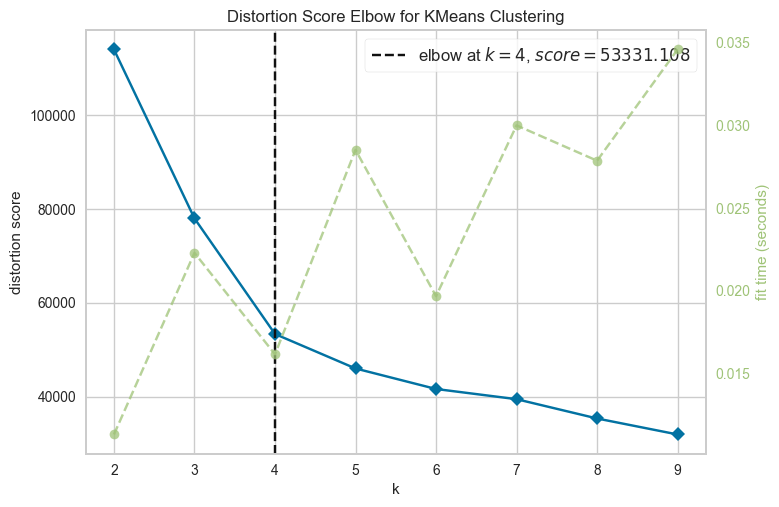

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [102]:
features = base_features_no_recency + rev_delay_features + time_of_the_day_feature
df_all_no_recency, scaled_df_all_no_recency = scale_data_and_plot_distributions(
    df_customers, features, plot=False
)
# scaled_df_all_no_recency = scaler.fit_transform(scaled_df_all_no_recency)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric="distortion", timings=True)

visualizer.fit(scaled_df_all_no_recency)
visualizer.poof()

In [103]:
for k in range(3, 5):
    df_labels = df_customers.copy()
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)

    df_labels["cluster"] = kmeans.fit_predict(scaled_df_all_no_recency)

    print(f"Results for {k} clusters")
    # Calculate the silhouette score
    silhouette = silhouette_score(scaled_df_all_no_recency, df_labels["cluster"])
    print(f"Silhouette score for {k} clusters: {silhouette}")

    # Benchmark the clusters
    benchmark_clusters(df_labels)


Results for 3 clusters
Silhouette score for 3 clusters: 0.3792368516173284


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4889,5.23,229.16,1.175905,200.75,981443.00,4.92,1.81,36.95,13.11,Evening
1,1,33788,36.17,240.26,1.527821,437.05,14767197.19,74.01,4.09,11.84,0.03,Evening
2,2,54729,58.59,244.66,1.065907,76.80,4203386.51,21.07,4.29,10.61,0.02,Evening


Results for 4 clusters
Silhouette score for 4 clusters: 0.31604704380924314


,cluster_,customers,customers(%),average_recency,average_orders,average_basket(real),total_revenues(real),total_revenues(%),average_review_score,delivery(days),late_deliveries(days),usual_moment_of_order
0,0,4835,5.18,228.50,1.164426,185.88,898710.71,4.50,1.81,36.99,13.18,Evening
1,1,13640,14.60,242.39,1.993622,790.39,10780872.92,54.03,3.90,12.02,0.08,Evening
2,2,34865,37.33,246.72,1.050997,55.07,1920134.59,9.62,4.29,10.29,0.03,Evening
3,3,40066,42.89,239.99,1.154121,158.55,6352308.48,31.84,4.25,11.49,0.02,Evening


# Conclusion

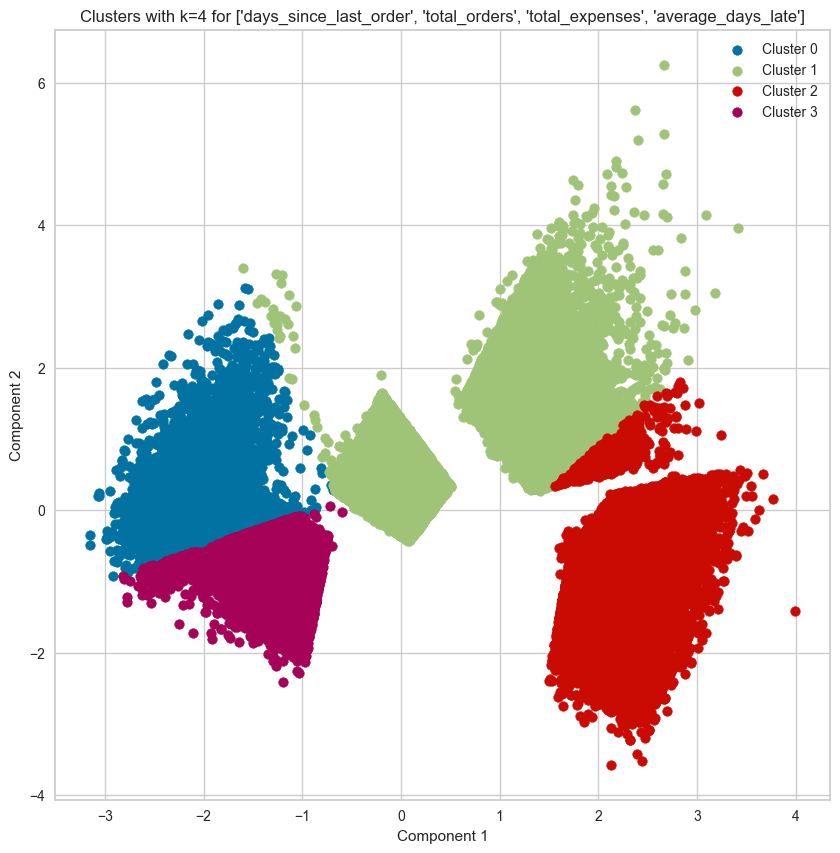

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_11411/1140008571.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


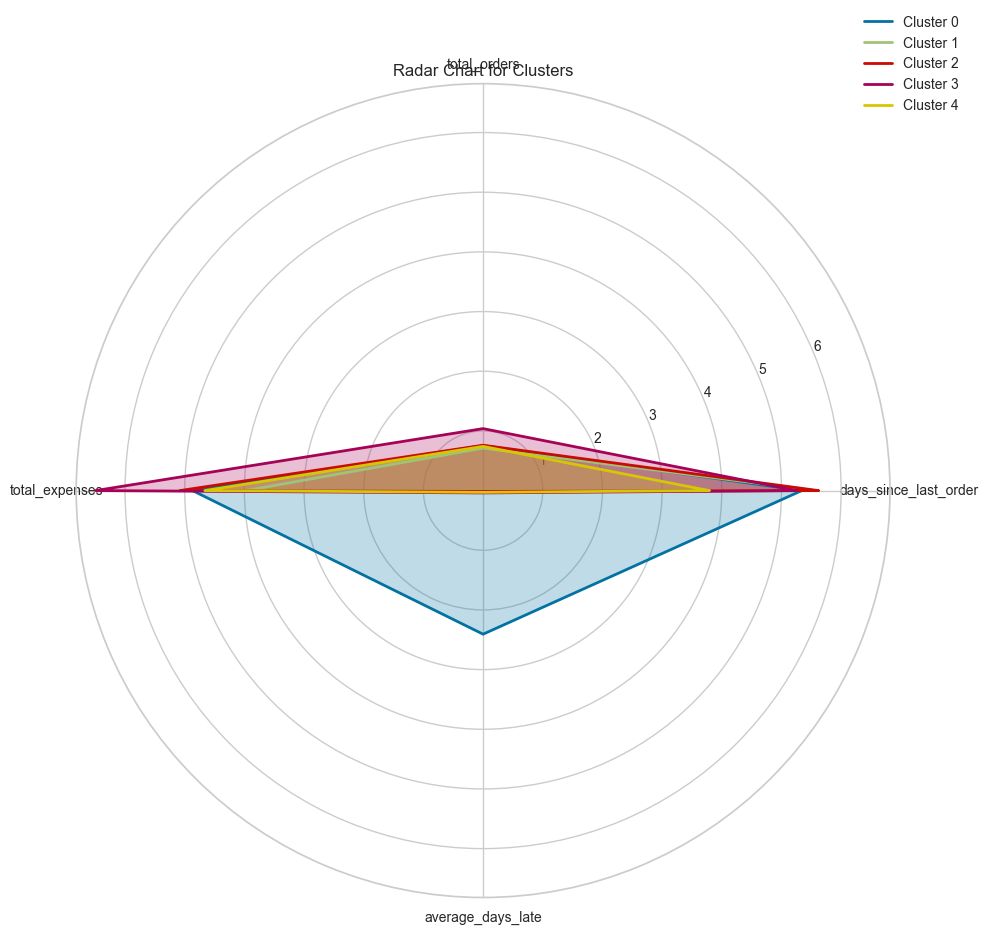

In [113]:
kmeans = KMeans(n_clusters=5, random_state=42, max_iter=300)

df_deliveries["cluster"] = kmeans.fit_predict(scaled_df_deliveries)
scaled_df_deliveries["cluster"] = df_deliveries["cluster"]

plot_two_dim_clusters(df_deliveries, scaled_df_deliveries, 4)
plot_radar_chart(scaled_df_deliveries)